Benchmarking...
Single-process execution time: 51.11 seconds


Running Simulations:   0%|          | 0/1000 [00:00<?, ?it/s]

Parallel execution time: 11.24 seconds


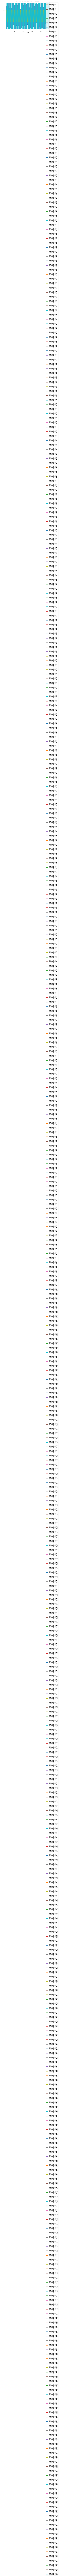

In [1]:
import numpy as np
from scipy.integrate import odeint
from joblib import Parallel, delayed
import matplotlib.pyplot as plt
import time
from tqdm.notebook import tqdm
from numba import jit

# Accelerate the ODE system using numba
@jit(nopython=True)
def simple_oscillator(y, t):
    x, v = y  # y[0] = position (x), y[1] = velocity (v)
    dxdt = v  # dx/dt = v
    dvdt = -x  # dv/dt = -x
    return [dxdt, dvdt]

# Function to simulate a batch of initial conditions
def simulate_batch(batch):
    t = np.linspace(0, 1000, 100000)  # Larger time steps for benchmarking
    results = [(t, odeint(simple_oscillator, ic, t, atol=1e-9)) for ic in batch]
    return results

# Function to run simulations using joblib for parallelism
def parallel_simulations(initial_conditions_list, batch_size=2):
    # Split the initial conditions into batches to reduce overhead
    batches = [
        initial_conditions_list[i:i + batch_size]
        for i in range(0, len(initial_conditions_list), batch_size)
    ]
    
    # Run parallel simulations with joblib
    results = Parallel(n_jobs=-1)(
        delayed(simulate_batch)(batch) for batch in tqdm(batches, desc="Running Simulations")
    )
    
    # Flatten the list of batches into a single list of results
    return [item for batch_result in results for item in batch_result]

# Benchmarking function
def benchmark(initial_conditions_list):
    print("Benchmarking...")

    # Single-process execution
    start_time = time.time()
    single_process_results = [simulate_batch([ic])[0] for ic in initial_conditions_list]
    single_process_time = time.time() - start_time
    print(f"Single-process execution time: {single_process_time:.2f} seconds")

    # Parallel execution with joblib
    start_time = time.time()
    parallel_results = parallel_simulations(initial_conditions_list, batch_size=2)
    parallel_time = time.time() - start_time
    print(f"Parallel execution time: {parallel_time:.2f} seconds")

    return single_process_results, parallel_results

# List of initial conditions for benchmarking
initial_conditions_list = [
    [1.0, 0.0],  # Initial position 1.0, velocity 0.0
    [0.5, 0.5],  # Initial position 0.5, velocity 0.5
    [-1.0, 0.0], # Initial position -1.0, velocity 0.0
    [0.0, 1.0],  # Initial position 0.0, velocity 1.0
    [2.0, -1.0]  # Initial position 2.0, velocity -1.0
] * 400  # Increase the workload for meaningful benchmarking

# Run the benchmark
single_process_results, parallel_results = benchmark(initial_conditions_list)

# Plotting all results on the same plot (using the parallel results)
plt.figure(figsize=(10, 6))
for i, (t, solution) in enumerate(parallel_results):
    plt.plot(t, solution[:, 0], label=f'Initial Condition {i+1}')

# Add labels, title, legend, and grid
plt.xlabel('Time (t)')
plt.ylabel('Position (x)')
plt.title('ODE Simulations: Simple Harmonic Oscillator')
plt.legend(loc='upper right', bbox_to_anchor=(1.15, 1))
plt.grid(True)

# Display the plot
plt.show()